In [35]:
import os
import sys
sys.path.append('common')
import util, audio_preprocessing

import shutil
import numpy as np
import keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint, Callback, TensorBoard
from matplotlib import pyplot as plt
%matplotlib inline
from cyclic_lr import CyclicLR

from dataset import SingleDataset, MultiDataset
from model import model_mlt_cnn_alexnet

TRY = 'MIX3scd100'
LOG_DIR = './%slog' % TRY
SCD_PREFIX = 'scd_'
USD_PREFIX = 'usd_'

batch_size = 32
epochs = 150

scd = SingleDataset(SCD_PREFIX,
                   util.load_txt_list(os.path.join('.', SCD_PREFIX+'classes.txt')),
                   batch_size)
usd = SingleDataset(USD_PREFIX,
                   ['air_conditioner',  'car_horn', 'children_playing', 'dog_bark', 'drilling',
                    'engine_idling', 'gun_shot','jackhammer', 'siren', 'street_music'],
                   batch_size)

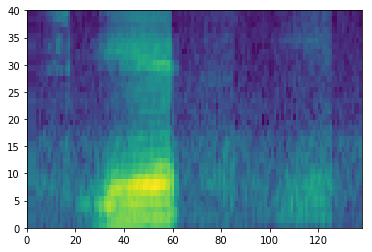

In [37]:
multi = MultiDataset([scd, usd], [1, 0])

# Confirmation
def plot_dataset(X, n=1):
    for i in range(n):
        x = X[i]
        plt.pcolormesh(x[..., -1])
        plt.show()
X = next(multi.train_generator)[0]
plot_dataset(X)

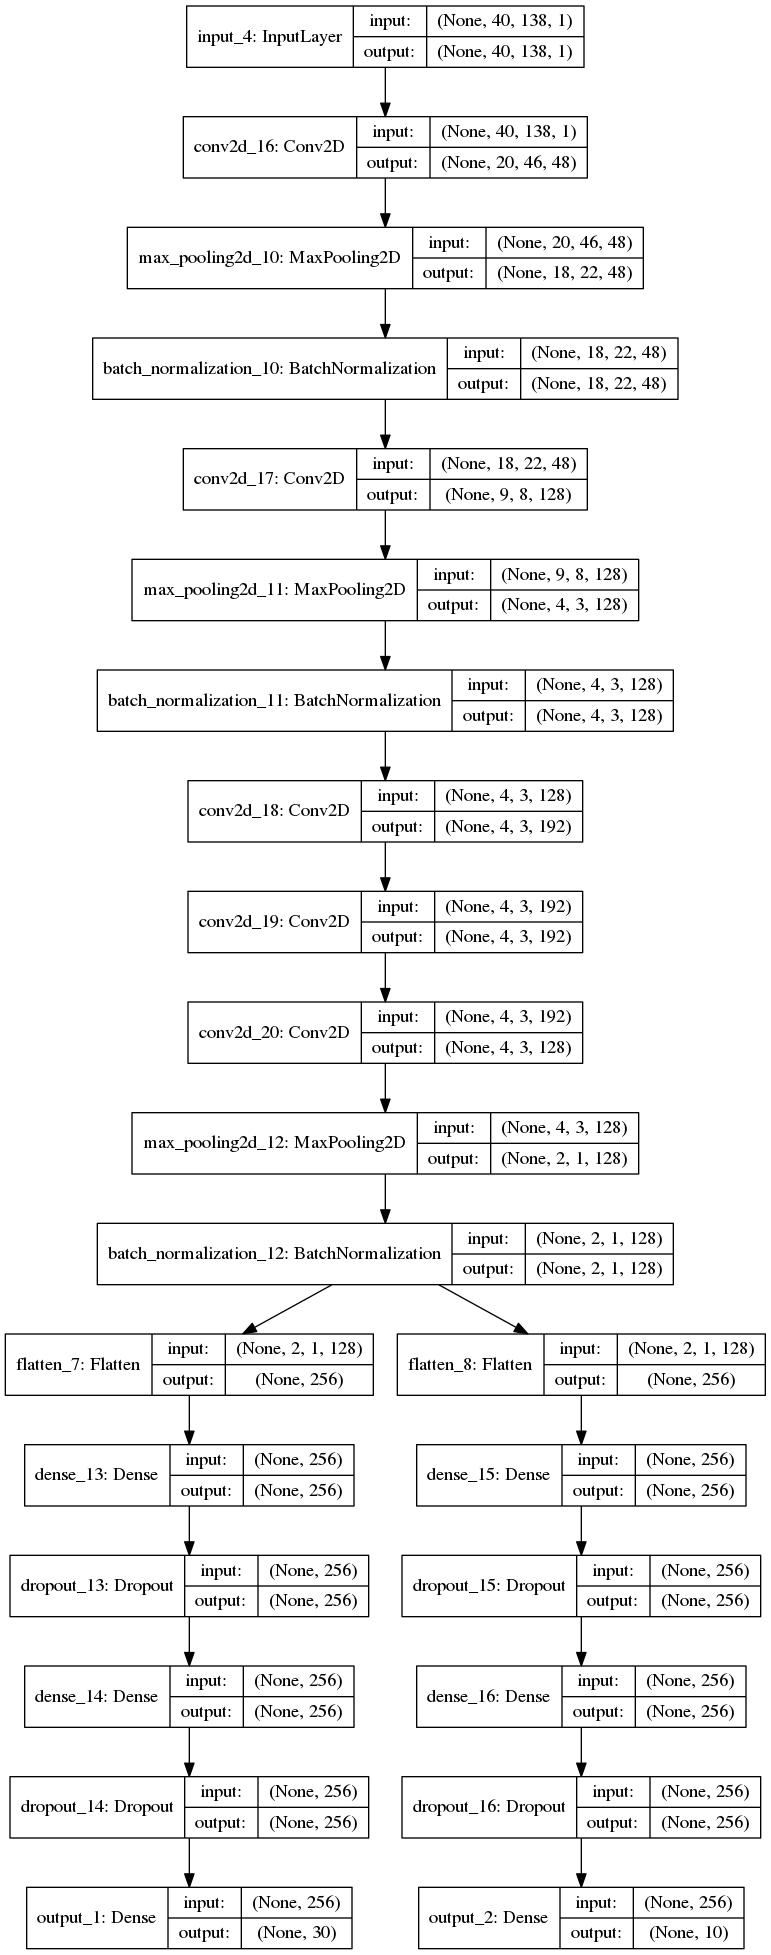

In [39]:
model = model_mlt_cnn_alexnet(multi.input_shape(), multi.ys_classes())
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
#model.summary()
from keras.utils import plot_model
plot_model(model, to_file='structure%s.png' % TRY, show_shapes=True)
from IPython.display import Image
Image(filename='structure%s.png' % TRY) 

In [40]:
callbacks = [
    CyclicLR(base_lr=0.00007, max_lr=0.0007, step_size=multi.train_steps_per_epoch, mode='triangular'),
    ModelCheckpoint('model%s.h5' % TRY,
                monitor='val_output_1_acc',
                verbose=1,
                save_best_only=True,
                save_weights_only=True),
     keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=True, write_images=True)
]

# Clean up log
shutil.rmtree(LOG_DIR, ignore_errors=True)

model.fit_generator(multi.train_generator,
                    steps_per_epoch=multi.train_steps_per_epoch,
                    epochs=epochs,
                    validation_data=multi.valid_generator, 
                    validation_steps=multi.valid_steps_per_epoch,
                    callbacks=callbacks)

Epoch 1/150
1594/1596 [============================>.] - ETA: 0s - loss: 3.4208 - output_1_loss: 3.4208 - output_2_loss: 0.0000e+00 - output_1_acc: 0.0525 - output_2_acc: 0.0408
Epoch 00001: val_output_1_acc improved from -inf to 0.14291, saving model to modelMIX3scd100.h5
1596/1596 [==============================] - 75s 47ms/step - loss: 3.4207 - output_1_loss: 3.4207 - output_2_loss: 0.0000e+00 - output_1_acc: 0.0526 - output_2_acc: 0.0408 - val_loss: 3.0020 - val_output_1_loss: 3.0020 - val_output_2_loss: 0.0000e+00 - val_output_1_acc: 0.1429 - val_output_2_acc: 0.0000e+00
Epoch 2/150
1595/1596 [============================>.] - ETA: 0s - loss: 3.0518 - output_1_loss: 3.0518 - output_2_loss: 0.0000e+00 - output_1_acc: 0.1577 - output_2_acc: 0.0338
Epoch 00002: val_output_1_acc improved from 0.14291 to 0.42244, saving model to modelMIX3scd100.h5
1596/1596 [==============================] - 74s 47ms/step - loss: 3.0519 - output_1_loss: 3.0519 - output_2_loss: 0.0000e+00 - output_1_acc

KeyboardInterrupt: 

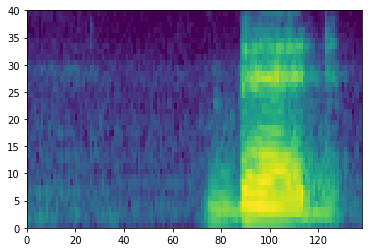

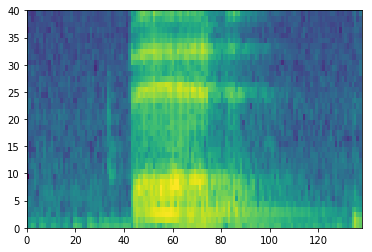

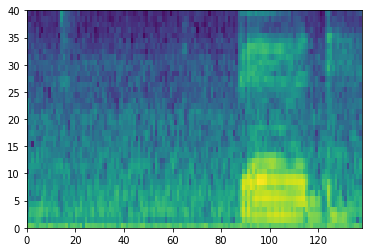

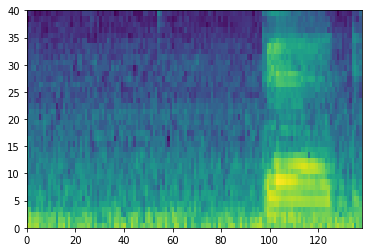

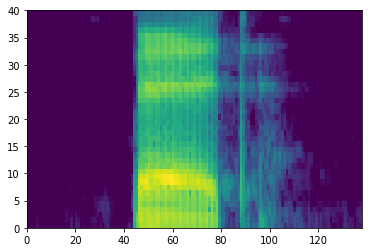

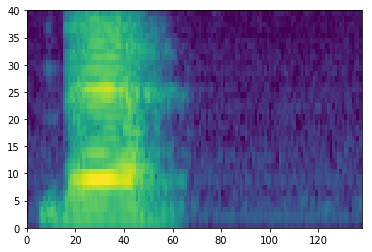

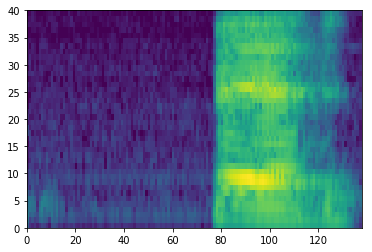

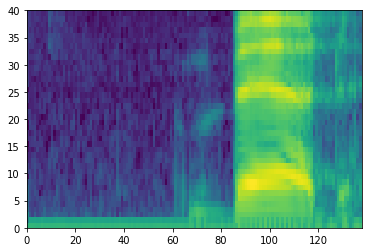

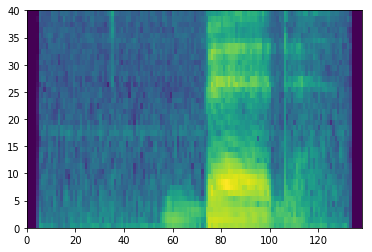

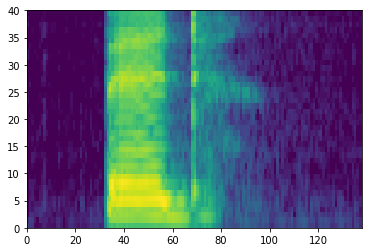

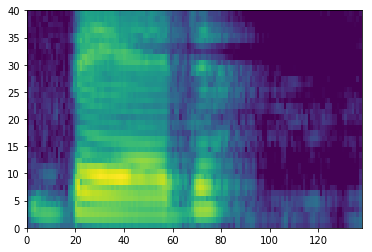

In [65]:
plot_dataset(a[0], n=1)
multi.reset()
for _ in range(10):
    plot_dataset(next(multi.valid_generator)[0])